In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data  import DataLoader, Dataset, Sampler
import torchvision.transforms as transforms

from tqdm import tqdm
from typing import Optional, Tuple

from rival10 import *
RIVAL10_constants.set_rival10_dir("/home/ksas/Public/datasets/RIVAL10/")

def load_local_rival10(batch_size:int = 16, 
                        num_workers:int = 4, 
                        preprocess:Optional[transforms.Compose]=None):

    trainset = LocalRIVAL10(train=True, 
                            masks_dict=True, 
                            transform=preprocess,
                            verbose = "key")
    testset = LocalRIVAL10(train=False, 
                            masks_dict=True, 
                            transform=preprocess,
                            verbose = "key")

    class_to_idx = {c: i for (i,c) in enumerate(RIVAL10_constants._ALL_CLASSNAMES)}
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    train_loader = DataLoader(trainset, batch_size=batch_size,
                                shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(testset, batch_size=batch_size,
                                shuffle=False, num_workers=num_workers)
    
    return trainset, testset, train_loader, test_loader, class_to_idx, idx_to_class

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

trainset, testset, train_loader, test_loader, class_to_idx, idx_to_class = load_local_rival10(preprocess = transform)

100%|██████████| 21144/21144 [00:00<00:00, 3184700.82it/s]


In [3]:
data = next(iter(train_loader))

for key in data.keys():
    if isinstance(data[key], torch.Tensor):
        print(f"\t{key}: \n{data[key].size()}")
    else:
        print(f"\t{key}: \n{data[key]}")

	img: 
torch.Size([16, 3, 224, 224])
	attr_labels: 
torch.Size([16, 18])
	changed_attrs: 
torch.Size([16, 18])
	merged_mask: 
torch.Size([16, 3, 224, 224])
	og_class_name: 
['cat', 'truck', 'truck', 'ship', 'bird', 'equine', 'deer', 'car', 'frog', 'plane', 'frog', 'equine', 'bird', 'dog', 'truck', 'equine']
	og_class_label: 
torch.Size([16])
	attr_masks: 
torch.Size([16, 19, 3, 224, 224])


In [4]:
import numpy as np
from matplotlib import interactive

def reduce_tensor_as_numpy(input:torch.Tensor) -> Tuple[np.ndarray, np.ndarray]:
    """
    Args:
        input: [1, C, W, H] or [C, W, H]
    
    Returns:
        [W, H, C]
    """
    if input.size().__len__() == 4:
        input.squeeze_(0)
    return input.permute((1, 2, 0)).detach().cpu().numpy()
                
def show_image(images:torch.Tensor, comparison_images:torch.Tensor=None):
    import torchvision
    import matplotlib.pyplot as plt
    
    if comparison_images is not None:
        images = torch.cat((images, comparison_images), dim=3)

    grid_img = torchvision.utils.make_grid(images, nrow=4, normalize=True)

    plt.imshow(grid_img.permute(1, 2, 0)) 
    plt.axis('off')
    plt.show()
    
def getAttMap(img, attn_map, blur=True):
    import matplotlib.pyplot as plt
    from scipy.ndimage import filters
    def normalize(x: np.ndarray) -> np.ndarray:
        # Normalize to [0, 1].
        x = x - x.min()
        if x.max() > 0:
            x = x / x.max()
        return x

    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    # pos_mask = attn_map <= 0
    attn_map = normalize(attn_map)
    # attn_map[pos_mask] = 0
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn_multiple(batch_X:torch.Tensor, attributions:list[torch.Tensor], blur=True, prefix:str="", save_to:str=None):
    import matplotlib.pyplot as plt
    batch_X = reduce_tensor_as_numpy(batch_X)
    attributions = [reduce_tensor_as_numpy(attribution) for attribution in attributions]
    
    attn_map = []
    for attribution in attributions:
        attn_map.append(getAttMap(batch_X, attribution.sum(2), blur))

    
    _, axes = plt.subplots(1, 1 + attn_map.__len__(), figsize=(50, 10))
    axes[0].imshow(np.clip(batch_X, 0.0, 1.0))
    for idx, map in  enumerate(attn_map):
        axes[1 + idx].imshow(np.clip(map, 0.0, 1.0))
    
    for ax in axes:
        ax.axis("off")
    
    if save_to is not None:
        os.makedirs(save_to, exist_ok=True)
        plt.savefig(os.path.join(save_to, f"{prefix}-attn_image.jpg"), bbox_inches='tight', pad_inches=0.1)
        plt.close()
    else:
        plt.show()

# attr_template = None
# for idx, data in enumerate(testset):
#     if data["og_class_name"] != "plane":
#         continue

#     if attr_template is None:
#         attr_template = data["attr_labels"]
#     else:
#         print((data["attr_labels"] == attr_template).sum())
    # print(f"We're showing the No.{idx} sample")
    # viz_attn_multiple(data["img"],
    #     [data["attr_masks"][1]],)
    # import pdb; pdb.set_trace()

tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1])


/tmp/ipykernel_3098380/1954984082.py:40: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))


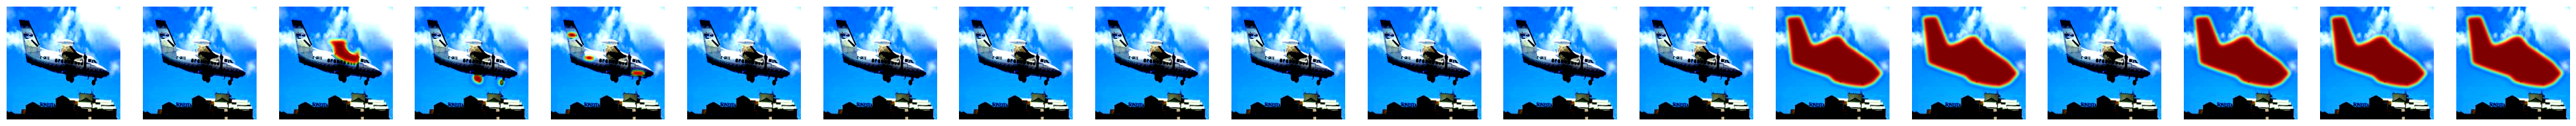

tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1])


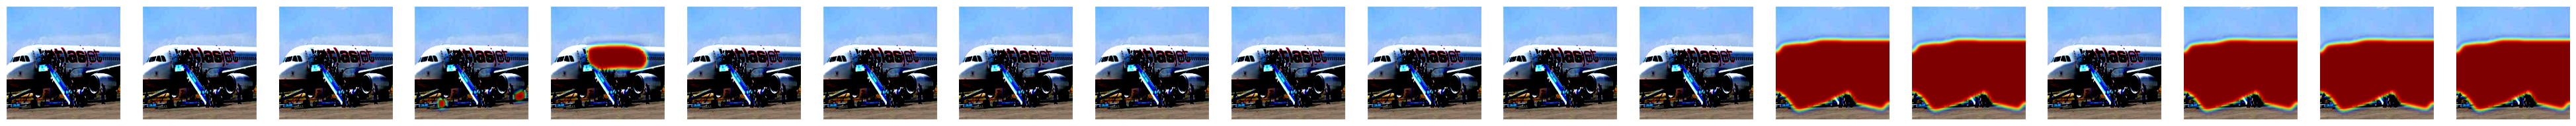

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0])


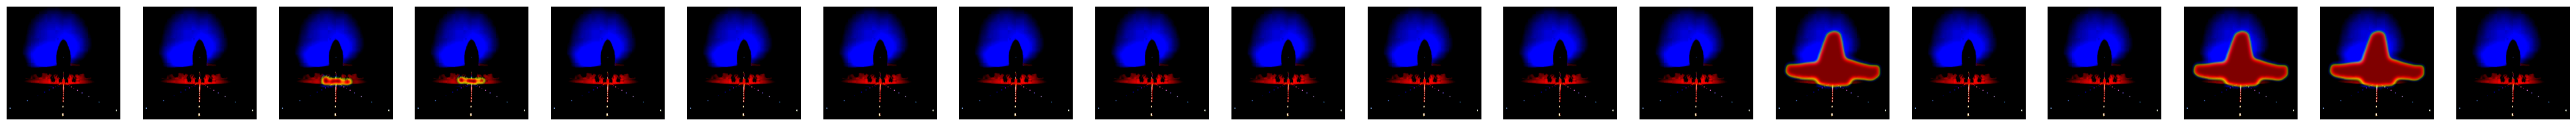

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0])


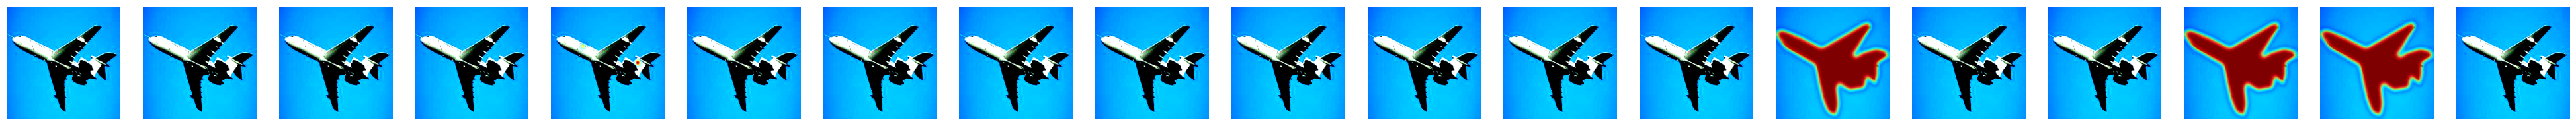

In [5]:
abnormal_sample_idx = [10, 19, 29, 35]

for idx in abnormal_sample_idx:
    data = testset[idx]
    print(data["attr_labels"])
    viz_attn_multiple(data["img"],
        [data["attr_masks"][i] for i in range(18)],)